# Libraries and Data

In [1]:
#change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [4]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [5]:
# Transforming the date variable: YYYY-MM-DD
df.ds = pd.to_datetime(df.ds, format = "%m/%d/%Y")

# Holidays

In [6]:
# Easter Holiday
dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [7]:
# Remaining Holidays
# Thanksgiving
dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                       'ds': dates,
                       'lower_window': -3,
                       'upper_window': 5})

#Christmas
dates = df[df.Christmas == 1].ds
christmas = pd.DataFrame({'holiday': 'christmas',
                       'ds': dates,
                       'lower_window': -7,
                       'upper_window': 7})

In [8]:
# Combine all events
holidays = pd.concat([easter, thanksgiving, christmas])
holidays.head()

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2


In [9]:
# Drop holidays from df
df_final = df.drop(columns = ["Easter", "Thanksgiving", "Christmas"])
df_final.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


# Prophet Model

In [10]:
from prophet import Prophet

In [11]:
# Building the model
m = Prophet(holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor("Temperature")
m.add_regressor("Marketing")
m.fit(df_final)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_getvn0m/mbk6fg5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_getvn0m/wxwuee1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76142', 'data', 'file=/tmp/tmp_getvn0m/mbk6fg5c.json', 'init=/tmp/tmp_getvn0m/wxwuee1b.json', 'output', 'file=/tmp/tmp_getvn0m/prophet_modelh_ndstnh/prophet_model-20231025073700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [12]:
from prophet.diagnostics import cross_validation

In [13]:
# How many days we have in the data set
df.shape[0] - 180

2012

In [ ]:
# Cross-Validation
df_cv = cross_validation(model = m,
                         horizon = '31 days',
                         period = '16 days',
                         initial = '2012 days',
                         parallel = 'processes')
df_cv.head()

In [15]:
# Look at the output
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,608.010933,541.203330,673.595389,571.069531,2020-07-09
1,2020-07-11,723.200025,655.423905,788.913436,677.106981,2020-07-09
2,2020-07-12,638.132957,564.108177,701.663944,619.572774,2020-07-09
3,2020-07-13,770.423504,704.909253,835.969776,808.932621,2020-07-09
4,2020-07-14,637.782537,575.339937,707.038633,661.791644,2020-07-09


In [19]:
# Performance metrics
from prophet.diagnostics import performance_metrics
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2848.893974,53.375031,43.990118,0.059668,0.062185,0.060776,0.800000
1,5 days,2805.738599,52.969223,44.404718,0.062093,0.065053,0.062892,0.767742
2,6 days,3496.002459,59.127003,50.260064,0.069488,0.065053,0.070911,0.703226
3,7 days,2785.545606,52.778268,42.616030,0.060060,0.058027,0.061109,0.703226
4,8 days,2738.341084,52.329161,40.225130,0.055593,0.057193,0.057089,0.732258


In [28]:
# RMSE and MAPE
rmse = round(performance_metrics(df_cv)["rmse"].mean(),1)
mape = round(performance_metrics(df_cv)["mape"].mean() * 100,3)
print(f"The RMSE is {rmse}")
print(f"The MAPE is {mape} %")

The RMSE is 54.0
The MAPE is 5.85 %


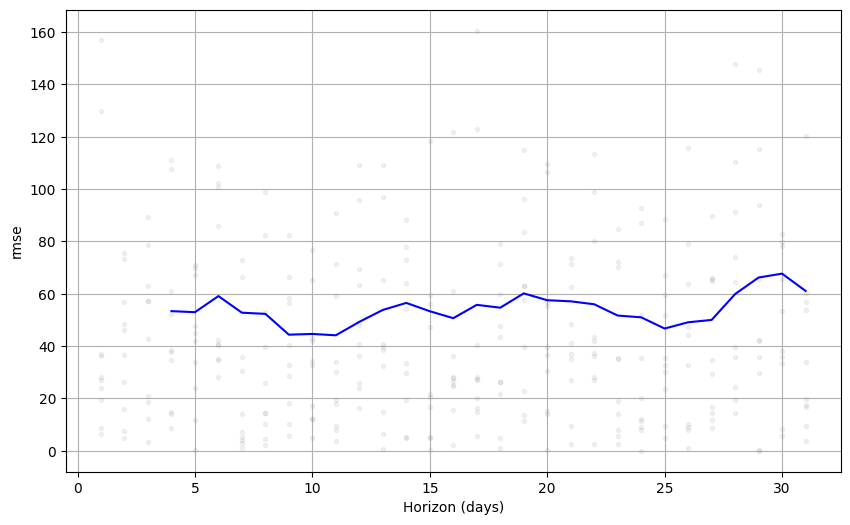

In [31]:
# Plotting the performance metrics over time
from prophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(df_cv, metric = 'rmse');

# Parameter Tuning

In [37]:
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_mode': ["additive", "multiplicative"],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
print(len(list(grid)))
print(list(grid))

54
[{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonalit

In [ ]:
# Store the results
rmse = []
i = 0

#loop
for params in grid:
  print(f"{i} out of {len(list(grid))}")
  # model
  # Building the model
  m = Prophet(holidays = holidays,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor("Temperature")
  m.add_regressor("Marketing")
  m.fit(df_final)

  # CV
  df_cv = cross_validation(model = m,
                          horizon = '31 days',
                          period = '16 days',
                          initial = '2012 days',
                          parallel = 'processes')

  # Measure and store error
  error = round(performance_metrics(df_cv)["rmse"].mean(),1)
  rmse.append(error)

  i += 1

In [40]:
# Parameter Tuning outcome
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.01,5,additive,5,48.7
1,0.01,5,additive,10,48.7
2,0.01,5,additive,20,48.5
3,0.01,5,multiplicative,5,49.9
4,0.01,5,multiplicative,10,49.9
5,0.01,5,multiplicative,20,49.8
6,0.01,10,additive,5,48.7
7,0.01,10,additive,10,48.8
8,0.01,10,additive,20,48.7
9,0.01,10,multiplicative,5,49.7


In [44]:
# Exporting the tuned parameters
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params.to_csv("Forecasting Product/best_params_prophet.csv")